# Crypto Trading Environment
### Overview
A reinforcement learning environment for trading crypto pairs. This environment is targeted at trading a single pair. In future iterations of this environment, we will explore allowing the trading of multiple pairs on the same environment.
### Features
- Allows for features / indicators / additional numerical data in the observation space.
- Memory allows for the current timestep's observation space to have X length of historical data most recent to the current timestep.
- Long-only positions as this is common in the crypto-world.
- When buying stakes, max_stake_count of stakes are allowed however when selling, the environment sells all stakes at once.
### References
|Reference|Relevance|
|--|--|
|[OpenAI Gym Base](https://github.com/openai/gym/blob/master/gym/core.py)|The base class for our environment. This interface seems to be a standard in the reinforcement learning space.|
|[AnyTrading Foundation](https://github.com/AminHP/gym-anytrading)|We used AnyTrading's work as a reference point for creating our own environment that's a little more talored to our needs.|

### Import Dependencies

In [97]:
import pickle

### Import Data
We use the lab we worked on before for market_trading > parse_market_data to get the latest market information from FrostAura Plutus.

In [98]:
model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

In [99]:
pair_name = 'AAVE_BTC'
pair_data = featurized_market_data[pair_name]

# This dataset contains open, close, high, low, volume and any numerical features / indicators you like.
price_movement_df = pair_data

### Import the Environment

In [100]:
%run ./fa.intelligence.notebooks/utilities/reinforcement_learning/environments/crypto_pair_trading_environment.ipynb

### End-to-end Random Agent Result
We take a bunch of random actions until the time or capital runs out and render the results.

C:\ProgramData\miniforge3\lib\site-packages\pandas\core\frame.py:3834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


Ran out of capital with 0 remaining open transactions. Environment is now done.
Rendering the environment results now. 8852 close price points and 256 transaction points. This may take a while.


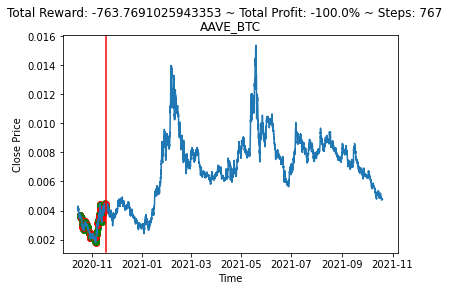

In [101]:
env = CryptoPairTradingEnv(pair_data, pair_name, max_stake_count=1)
observation = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

env.render()